Now that we have a dataset, some models and a sliding window, let's found the cars

In [1]:
import cv2
import numpy as np
from itertools import zip_longest

# Load image and boxes
image = cv2.imread("test/001.jpg")

def grouper(n, iterable, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

def overlap(box1, box2, threshold=0.5):
    """
    Determine if two boxes overlap based on their intersection over union (IoU).
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x1 >= x2 or y1 >= y2:
        return False
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = intersection / float(area1 + area2 - intersection)
    return iou >= threshold

# Create heatmap
def create_map(boxes, img):
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)

    for x,y,w, h in grouper(4, boxes):
        heatmap[y:y+h,x:x+w] += 1.0

    # Threshold heatmap
    threshold = 1
    heatmap[heatmap < threshold] = 0.0
    heatmap[heatmap >= threshold] = 1.0
    return heatmap

def connect_components(heatmap):
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(heatmap.astype(np.uint8))

    # Compute bounding boxes
    bboxes = []
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        bboxes.append([x, y, width, height])

    # Merge overlapping bounding boxes
    merged_bboxes = []
    while len(bboxes) > 0:
        bbox = bboxes.pop(0)
        merged_bbox = bbox
        i = 0
        while i < len(bboxes):
            if overlap(merged_bbox, bboxes[i]):
                merged_bbox = merge(merged_bbox, bboxes[i])
                bboxes.pop(i)
            else:
                i += 1
        merged_bboxes.append(merged_bbox)
    return merged_bboxes

def create_submission_file(boxes_list, files_names):
    rows = []
    for i, file_name in enumerate(files_names):
        rle = run_length_encoding(bounding_boxes_to_mask(boxes_list[i], H, W))
        rows.append(['test/' + file_name, rle])

    df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
    df_prediction.to_csv('sample_submission2.csv')
    print("file created")


### For one image

In [9]:
import pandas as pd
from utils import sliding_window
import numpy as np
import pickle
from utils import create_bounding_boxes_df
from skimage.feature import hog
import matplotlib.pyplot as plt

MODEL_PATH = "models/randomforest.model"
model = pickle.load(open(MODEL_PATH, "rb"))
sizes = [64,100,250]

img_path = "test/001.jpg"
image = cv2.imread(img_path)[:,:,::-1]
boxes = []
for size in sizes:
    for window, coords in sliding_window(image, size, stride = size//5):
        # resizing the image
        new_size = (64, 64)
        resized_window = cv2.resize(window, new_size)
        
        # Extracting the features
        fd, hog_image = hog(resized_window, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), visualize=True,channel_axis=-1)

        # Features reshaping
        fd = fd.reshape(-1, 1)
        fd = np.transpose(fd,(1,0))

        # Getting a probability
        proba = model.predict_proba(fd)

        if proba[0][1] > 0.85:
            boxes += [coords[0],coords[1] , coords[2], coords[3]]

img =  image[:,:,::-1]
heatmap = create_map(boxes, img)
merged_bboxes = connect_components(heatmap)

#df_boxes = create_bounding_boxes_df([merged_bboxes], [img_path])
um = cv2.UMat(img)

# Draw bounding boxes on image
for bbox in merged_bboxes:
    cv2.rectangle(um, (bbox[0], bbox[1]), (bbox[0]+ bbox[2], bbox[1]+ bbox[3]), (0, 255, 0), 2)

# Convert um back to numpy array
img = um.get()
fig, ax = plt.subplots(1,2, figsize = (25,50))
ax[0].imshow(heatmap)
ax[1].imshow(img)

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### For the whole dataset

In [33]:
test_files = sorted(os.listdir('./test/'))


['test/001.jpg', 'test/002.jpg', 'test/003.jpg', 'test/004.jpg', 'test/005.jpg']


/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Image:  001.jpg
Image:  002.jpg
Image:  003.jpg
Image:  004.jpg


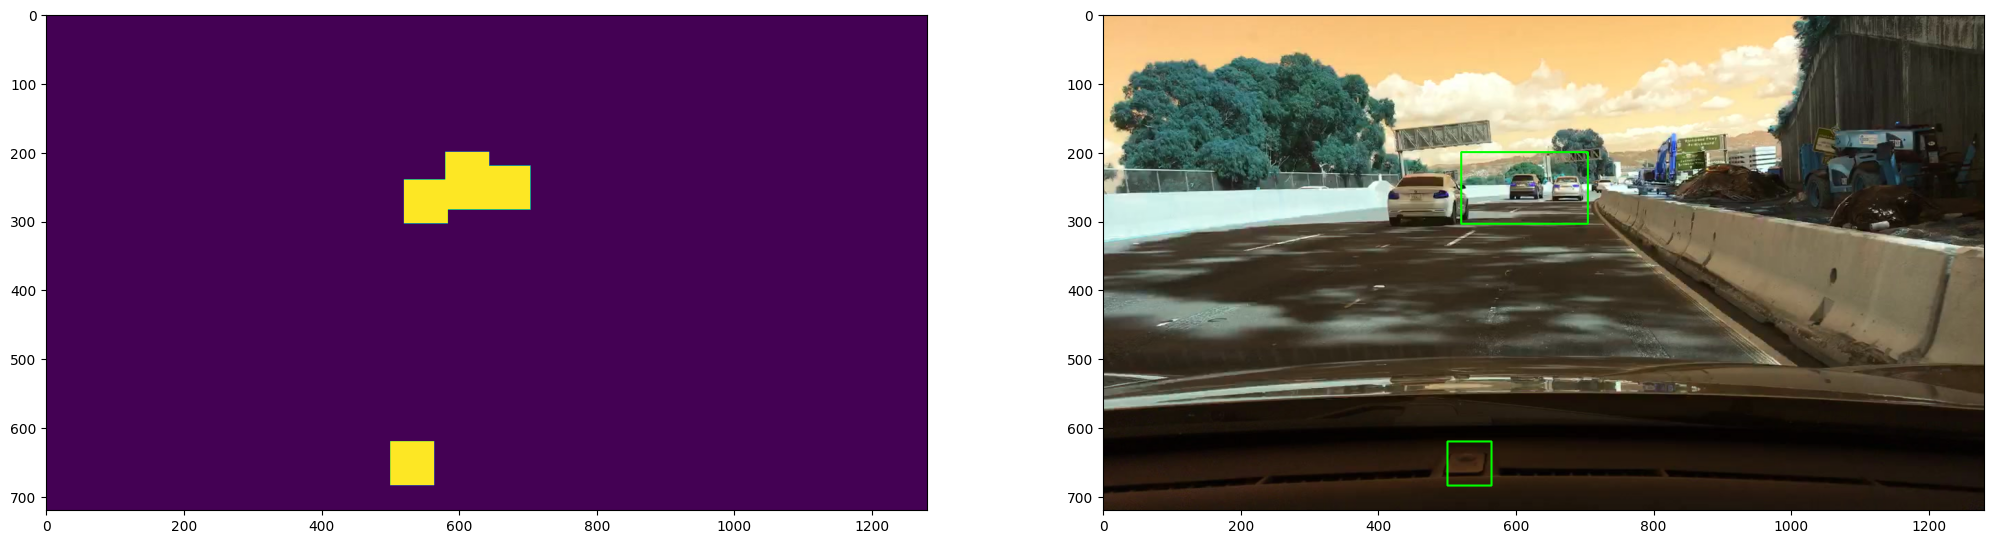

In [82]:
import pandas as pd
from utils import sliding_window
import numpy as np
import pickle
from utils import create_bounding_boxes_df
from skimage.feature import hog
import matplotlib.pyplot as plt

MODEL_PATH = "models/randomforest.model"
model = pickle.load(open(MODEL_PATH, "rb"))
sizes = [64, ]
boxes_list = []
test_files= test_files[:4]

for image_path in test_files:
    print("Image: ", image_path)
    image = cv2.imread(img_path)[:,:,::-1]
    boxes = []
    for size in sizes:
        for window, coords in sliding_window(image, size):
            # resizing the image
            new_size = (64, 64)
            resized_window = cv2.resize(window, new_size)
            
            # Extracting the features
            fd, hog_image = hog(resized_window, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), visualize=True,channel_axis=-1)

            # Features reshaping
            fd = fd.reshape(-1, 1)
            fd = np.transpose(fd,(1,0))

            # Getting a probability
            proba = model.predict_proba(fd)
            
            if proba[0][1] > 0.85:
                boxes += [coords[0],coords[1] , coords[2], coords[3]]

    img =  image[:,:,::-1]
    heatmap = create_map(boxes, img)
    merged_bboxes = connect_components(heatmap)
    boxes_list.append(merged_bboxes)

create_submission_file(boxes_list,test_files[:2])  

###### PLOT THE LAST IMAGE
um = cv2.UMat(img)

# Draw bounding boxes on image
for bbox in merged_bboxes:
    cv2.rectangle(um, (bbox[0], bbox[1]), (bbox[0]+ bbox[2], bbox[1]+ bbox[3]), (0, 255, 0), 2)

# Convert um back to numpy array
img = um.get()
fig, ax = plt.subplots(1,2, figsize = (25,50))
ax[0].imshow(heatmap)
ax[1].imshow(img)

In [85]:
create_submission_file(boxes_list,test_files)  

file created


In [50]:
images = boxes_list 

bounding_boxes = []
for img in images:
    bounding_boxes_str = ""
    for boxes in img:
        bounding_boxes_str += " "+' '.join(str(coord) for coord in boxes)
    bounding_boxes.append(bounding_boxes_str)
# Create dataframe with list of strings
pd.DataFrame(data={"frame_id": files[:2], "bounding_boxes": bounding_boxes})
    

,frame_id,bounding_boxes
0,test/001.jpg,520 200 184 104 500 620 64 64
1,test/002.jpg,520 200 184 104 500 620 64 64


In [68]:
boxes_list = [[[520, 200, 184, 104], [500, 620, 64, 64]],
 [[30, 200, 184, 104], [500, 620, 64, 64]]]